In [1]:
import numpy as np
import numpy.linalg as LA
from tqdm import tqdm

In [116]:
srho = 0.25**2
spsi = 0.0436**2
alpha = 0.05**0.01
l = 0.3
dt = 1

## Questão 1

In [3]:
def lp2lc(coords) -> np.array:
    rho, psi = coords
    return np.array([
        [rho*np.cos(psi)],
        [rho*np.sin(psi)],
    ])

def Q_lp2lc(obs) -> np.array:
    rho, psi = obs
    return np.array([
        [rho**2 * spsi * np.sin(psi)**2 + srho * np.cos(psi)**2, 0.5*(-rho**2 * spsi + srho)*np.sin(2*psi)],
        [0.5*(-rho**2 * spsi + srho)*np.sin(2*psi), rho**2 * spsi * np.cos(psi)**2 + srho * np.sin(psi)**2]
    ])

## Questão 2

In [4]:
def R_lc2g(theta: float) -> np.array:
    '''
    Rotation matrix from Local Cartesiano to Global
    '''
    return np.array([
            [ np.cos(theta),-np.sin(theta)],
            [ np.sin(theta), np.cos(theta)]
    ])

def A_lc2g(robot: np.array) -> np.array:
    '''
    Homogenous matrix from Local Cartesiano to Global
    '''    
    x, y, theta = robot
    return np.array([
        [ np.cos(theta), -np.sin(theta), x],
        [ np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

def lc2g(coords_lc: np.array, robot: np.array) -> np.array:
    x_lc, y_lc = coords_lc
    return (A_lc2g(robot) @ np.array([[x_lc[0]], [y_lc[0]], [1]]))[:2]

def Q_lc2g(theta: float, Q_lc: np.array) -> np.array:
    return R_lc2g(theta) @ Q_lc @ R_lc2g(theta).T

## Questão 3

In [5]:
def g2lc(coords_g: np.array, robot: np.array) -> np.array:
    A_g2lc = LA.inv(A_lc2g(robot))
    gx, gy = coords_g
    return (A_g2lc @ np.array([[gx], [gy], [1]]))[:2]

def C(theta):
    return R_lc2g(theta).T

def lc2lp(coords_lc: np.array) -> np.array:
    l, r = coords_lc
    return np.array([
        [np.sqrt(l**2+r**2)],
        [np.arctan2(r,l)]
    ])

## Questão 4

In [6]:
def check_sensor(x: float, y: float, theta_robot: float = np.pi/6) -> bool:
    print(f'X: {x}   Y: {y}')
    D_MAX = 3
    ANG_MAX = np.pi/3
    x_robot = 1
    y_robot = 2
    l, r = g2lc([x,y], [x_robot, y_robot, theta_robot])
    rho, psi = lc2lp([l,r])
    print(rho,psi)
    
    if rho <= D_MAX and (-ANG_MAX <= psi) and (psi <= ANG_MAX):
        print(True,'\n')
    else:
        print(False,'\n')

In [7]:
check_sensor(2,2)

X: 2   Y: 2
[[1.]] [[-0.52359878]]
True 



## Questão 5

In [38]:
class EKF_PARTICLE:
    def __init__(self, landmarks, robot_t0):
        self.landmarks = landmarks
        self.robot = robot_t0
        
    @staticmethod
    def Lj(land, obs, robot_t):
        '''
        land = [mu, sigma]
        mu = [x_bar, y_bar]
        obs = [rho, psi]
        '''
        return C(robot_t[2]) @ land['sigma'] @ C(robot_t[2]).T + Q_lp2lc(obs)
    
    def compute_W(self, observations_t, robot_t):
        '''
        Observations_t = todas as obs de um mesmo timestamp
        Robot_t = estado do robo no timestamp
        '''
        m = len(self.landmarks)
        n = len(observations_t)
        if m == 0:
            #necessario para o caso inicial, onde nao existem landmarks
            self.W = np.zeros((n,1))
        else:   
            W = np.zeros((n,m))
            for i, obs in enumerate(observations_t):
                for j, land in enumerate(self.landmarks):
                    d = lp2lc(obs) - g2lc(land['mu'], robot_t)
                    L = self.Lj(land, obs, robot_t)
                    W[i][j] = 1 / np.sqrt(LA.det(2*np.pi*L)) * np.exp(-(d.T @ LA.inv(L) @ d)/2)

            self.W = W

    def attribute_landmarks(self, observations_t, robot_t):
        W = self.W.copy()
        c = []
        new_landmarks = []
        n, m = W.shape
        while True:
            i,j = np.unravel_index(np.argmax(W), W.shape)
            max_W = np.max(W)
            if max_W == -1:
                break
            elif max_W >= alpha:
                c.append({'observation':i, 'landmark': j, 'weight': max_W})
                W[i,:] = -1
                W[:,j] = -1
            else:
                #create new landmark
                obs = observations_t[i]
                initial_mu = lc2g(lp2lc(obs), robot_t).T[0]
                initial_sigma = Q_lc2g(robot_t[2], Q_lp2lc(obs))
                new_landmarks.append({'mu':initial_mu, 'sigma':initial_sigma, 'count':1}) 
                c.append({'observation':i, 'landmark': m+len(new_landmarks)-1, 'weight': alpha})
                W[i,:] = -1
        
        self.attributions = c
        self.new_landmarks = new_landmarks
        return c, new_landmarks
    
    def Kalman_Gain(self,land, robot_t, obs):
        K = land['sigma'] @ C(robot_t[2]).T @ LA.inv(self.Lj(land, obs, robot_t))
        return K
    
    def update_landmarks(self, observation_t, robot_t):
        landmarks_seen = []
        for i, att in enumerate(self.attributions):
            if att['landmark'] >= len(self.landmarks):
                # if new landmark
                pass
            else:
                land = self.landmarks[att['landmark']]
                obs = observation_t[att['observation']]
                d = lp2lc(obs) - g2lc(land['mu'], robot_t)
                K = self.Kalman_Gain(land,robot_t,obs)
                land['mu'] += (K @ d).T[0]
                land['sigma'] = (np.eye(K.shape[0]) - K @ C(robot_t[2])) @ land['sigma']
                self.landmarks[att['landmark']] = land
                
                # só preciso atualizar o count dos landmarks antigos
                landmarks_seen.append(att['landmark'])
        
        idx2pop = []
        for i, land in enumerate(self.landmarks):
            # atualiza counters dos landmarks
            if i not in landmarks_seen:
                land['count'] -= 1
                if land['count'] == 0:
                    idx2pop.append(i)
            else:
                land['count'] += 1
            
        # deletar landmarks com count=0
        for i in sorted(idx2pop, reverse=True):
            del self.landmarks[i]
    
    def compute_particle_weight(self):
        total_weight = 1
        for el in self.attributions:
            total_weight *= el['weight']
        self.particle_weight = total_weight
        
    def extrapolate(self, u_t):
        """
        Extrapola a posição da partícula
        u_t : controle daquele timestamp
        """
        self.robot = np.random.multivariate_normal(F(self.robot, u_t), R(self.robot, u_t))        
                
    def fastSLAM_t(self, observation_t):
        self.compute_W(observation_t, self.robot)
        self.attribute_landmarks(observation_t, self.robot)
        self.update_landmarks(observation_t, self.robot)
        self.landmarks += self.new_landmarks
        self.compute_particle_weight()

        return self.attributions, self.landmarks

In [117]:
Z = [[3, 0],
    [4, -0.646],
    [np.sqrt(2), np.pi/8]]
Z = np.array([Z])
robot_t = np.array([4, 3, -np.pi/2])
landmarks = [
    [[2.,1], [[1/9,0],
             [0,1.]]],
    [[3.,-1], [[5/9,4/9],
              [5/9,4/8.]]],
    [[5/2,2], [[1/9,0],
             [0,1.]]],
]
# aqui os landmarks sao inicializados como 2 apenas para facilitar o codigo e possibitar
# acesso ao mapa atualizado incluindo o landmark que nao foi atribuido a nenhuma observacao
landmarks = [{'mu':np.array(l[0]), 'sigma':np.array(l[1]), 'count':2} for l in landmarks]

ekf_q5 = EKF_PARTICLE(landmarks, robot_t)
attributions, landmarks = ekf_q5.fastSLAM_t(Z[0])
ekf_q5.compute_particle_weight()

In [118]:
f'Peso da particula {ekf_q5.particle_weight}'

'Peso da particula 0.9140482050108684'

In [12]:
print('Mapa atualizado')
for i, land in enumerate(landmarks):
    print(f'Landmark {i}')
    print(f'mu: {land["mu"]}')
    print(f'sigma: {land["sigma"]}')

Mapa atualizado
Landmark 0
mu: [ 1.71630326 -0.09871928]
sigma: [[0.03038221 0.01066319]
 [0.01066319 0.04700132]]
Landmark 1
mu: [ 3.97314494 -0.01421739]
sigma: [[0.01491948 0.00631884]
 [0.00789855 0.03275703]]
Landmark 2
mu: [2.5 2. ]
sigma: [[0.11111111 0.        ]
 [0.         1.        ]]
Landmark 3
mu: [4.5411961  1.69343704]
sigma: [[ 0.01239805 -0.02075291]
 [-0.02075291  0.05390387]]


## Questão 6

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv('./data/valoresEP2.csv', usecols=np.arange(14), header=None).to_numpy()
control_hist = data[:,:2]
observations = []
for observation_t in data[:,2:]:
    observation_t = observation_t[~np.isnan(observation_t)]
    observation_t = observation_t.reshape(int(observation_t.shape[0]/2), 2)
    observations.append(observation_t)          

In [15]:
def F(X_prev: np.array, u_prev: np.array, dt=1) -> np.array:
    '''
    Calculada analiticamente.
    '''
    l=0.3
    return np.array([
        X_prev[0] + u_prev[0] * np.cos(u_prev[1]) *  np.cos(X_prev[2]) * dt,
        X_prev[1] + u_prev[0] * np.cos(u_prev[1]) *  np.sin(X_prev[2]) * dt,
        X_prev[2] + u_prev[0] * dt * np.tan(u_prev[1])/ l
    ])

In [16]:
X = [[0,0,0]]
for i, u in enumerate(control_hist):
    X.append(F(X[-1], u))

In [17]:
X = np.array(X)

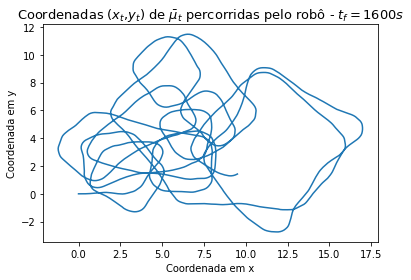

In [76]:
plt.plot(X[:,0], X[:,1])
plt.ylabel('Coordenada em y')
plt.xlabel('Coordenada em x')
plt.title(r'Coordenadas ($x_t$,$y_t$) de $\bar{\mu}_{t}$ percorridas pelo robô - $t_f=1600s$', fontsize=13)
plt.savefig('./images/caminhoEP2Q6.png', dpi=600)
plt.show()

## Questão 7

In [20]:
def R(x_prev, u):
    '''
    DE ESTADO
    '''
    cos = np.cos(x_prev[2])
    sin = np.sin(x_prev[2])
    M =  np.array([
        [cos, -sin, 0],
        [sin,  cos, 0],
        [0, 0, 1]
    ])
    
    sl = (dt * u[0] / 6)**2
    sr = (dt * u[0] / 12)**2
    stheta = (dt * u[0] / (8*l))**2
    
    # Matriz R no referencial local
    Rl = np.array([
        [sl, 0, 0],
        [0, sr, 0],
        [0, 0, stheta,]
    ])
    
    return M @ Rl @ M.T

In [102]:
N_PARTICLES = 10


def ressample_particles(particles):
    """
    Recebe as partículas e ressampleia novas 200 com base nos pesos das partículas.
    """
    weights = np.array([p.particle_weight for p in particles])
    weights /= weights.sum()
    new_particles = np.random.choice(particles,
                                     size=(N_PARTICLES,),
                                     p = weights)
    return new_particles
    
    
def particles_mean(particles):
    """
    Pega a média dos estados das partículas
    """
    return np.mean(
        np.array([p.robot for p in particles]),
        axis=0
    )


# def Q7(observations, control_history):
particles = []
robot_mean_history = []
for _ in range(N_PARTICLES):
    particle = EKF_PARTICLE(landmarks=[], robot_t0=np.zeros(3))
    particles.append(particle)

for t, observation_t in tqdm(enumerate(observations)):
    for particle in particles:
        particle.extrapolate(control_hist[t])
        particle.fastSLAM_t(observation_t)
    particles = ressample_particles(particles)        
    robot_mean = particles_mean(particles)
    robot_mean_history.append(robot_mean)

# return robot_mean_history, particles

1600it [02:14, 11.90it/s]


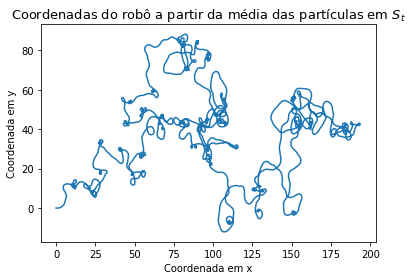

In [103]:
plt.plot(np.array(robot_mean_history)[:,0], np.array(robot_mean_history)[:,1])
plt.ylabel('Coordenada em y')
plt.xlabel('Coordenada em x')
plt.title(r'Coordenadas do robô a partir da média das partículas em $S_t$', fontsize=13)
plt.savefig(f'./images/caminhoEP2Q7_N{N_PARTICLES}.png', dpi=600)
plt.show()

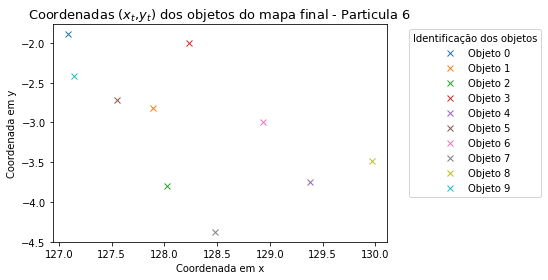

In [115]:
random_particle = np.random.randint(10)
final_map = particles[random_particle].landmarks
for i, land in enumerate(final_map):
    plt.plot(land['mu'][0], land['mu'][1],'x', label=f'Objeto {i}')
plt.ylabel('Coordenada em y')
plt.xlabel('Coordenada em x')
plt.legend(title='Identificação dos objetos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(r'Coordenadas ($x_t$,$y_t$) dos objetos do mapa final'+f' - Particula {random_particle}', fontsize=13)
plt.savefig(f'./images/caminhoEP2Q7_2_n{N_PARTICLES}.png', dpi=600)
plt.show()